In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from matplotlib.gridspec import GridSpec
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv('/home/ryley/WDK/ML/dataset/komega_phll.csv')

Model iterations: 50
[0 0 0 ... 0 0 0]
[0 1 2]
[0 0 0 ... 0 0 0]
[0 1 2]
[0 0 0 ... 0 0 0]
[0 1 2]
[0 0 0 ... 0 0 0]
[0 1 2]
[0 0 0 ... 0 0 0]
[0 1 2]
(array([0, 1, 2]), array([13816, 17568, 42371]))


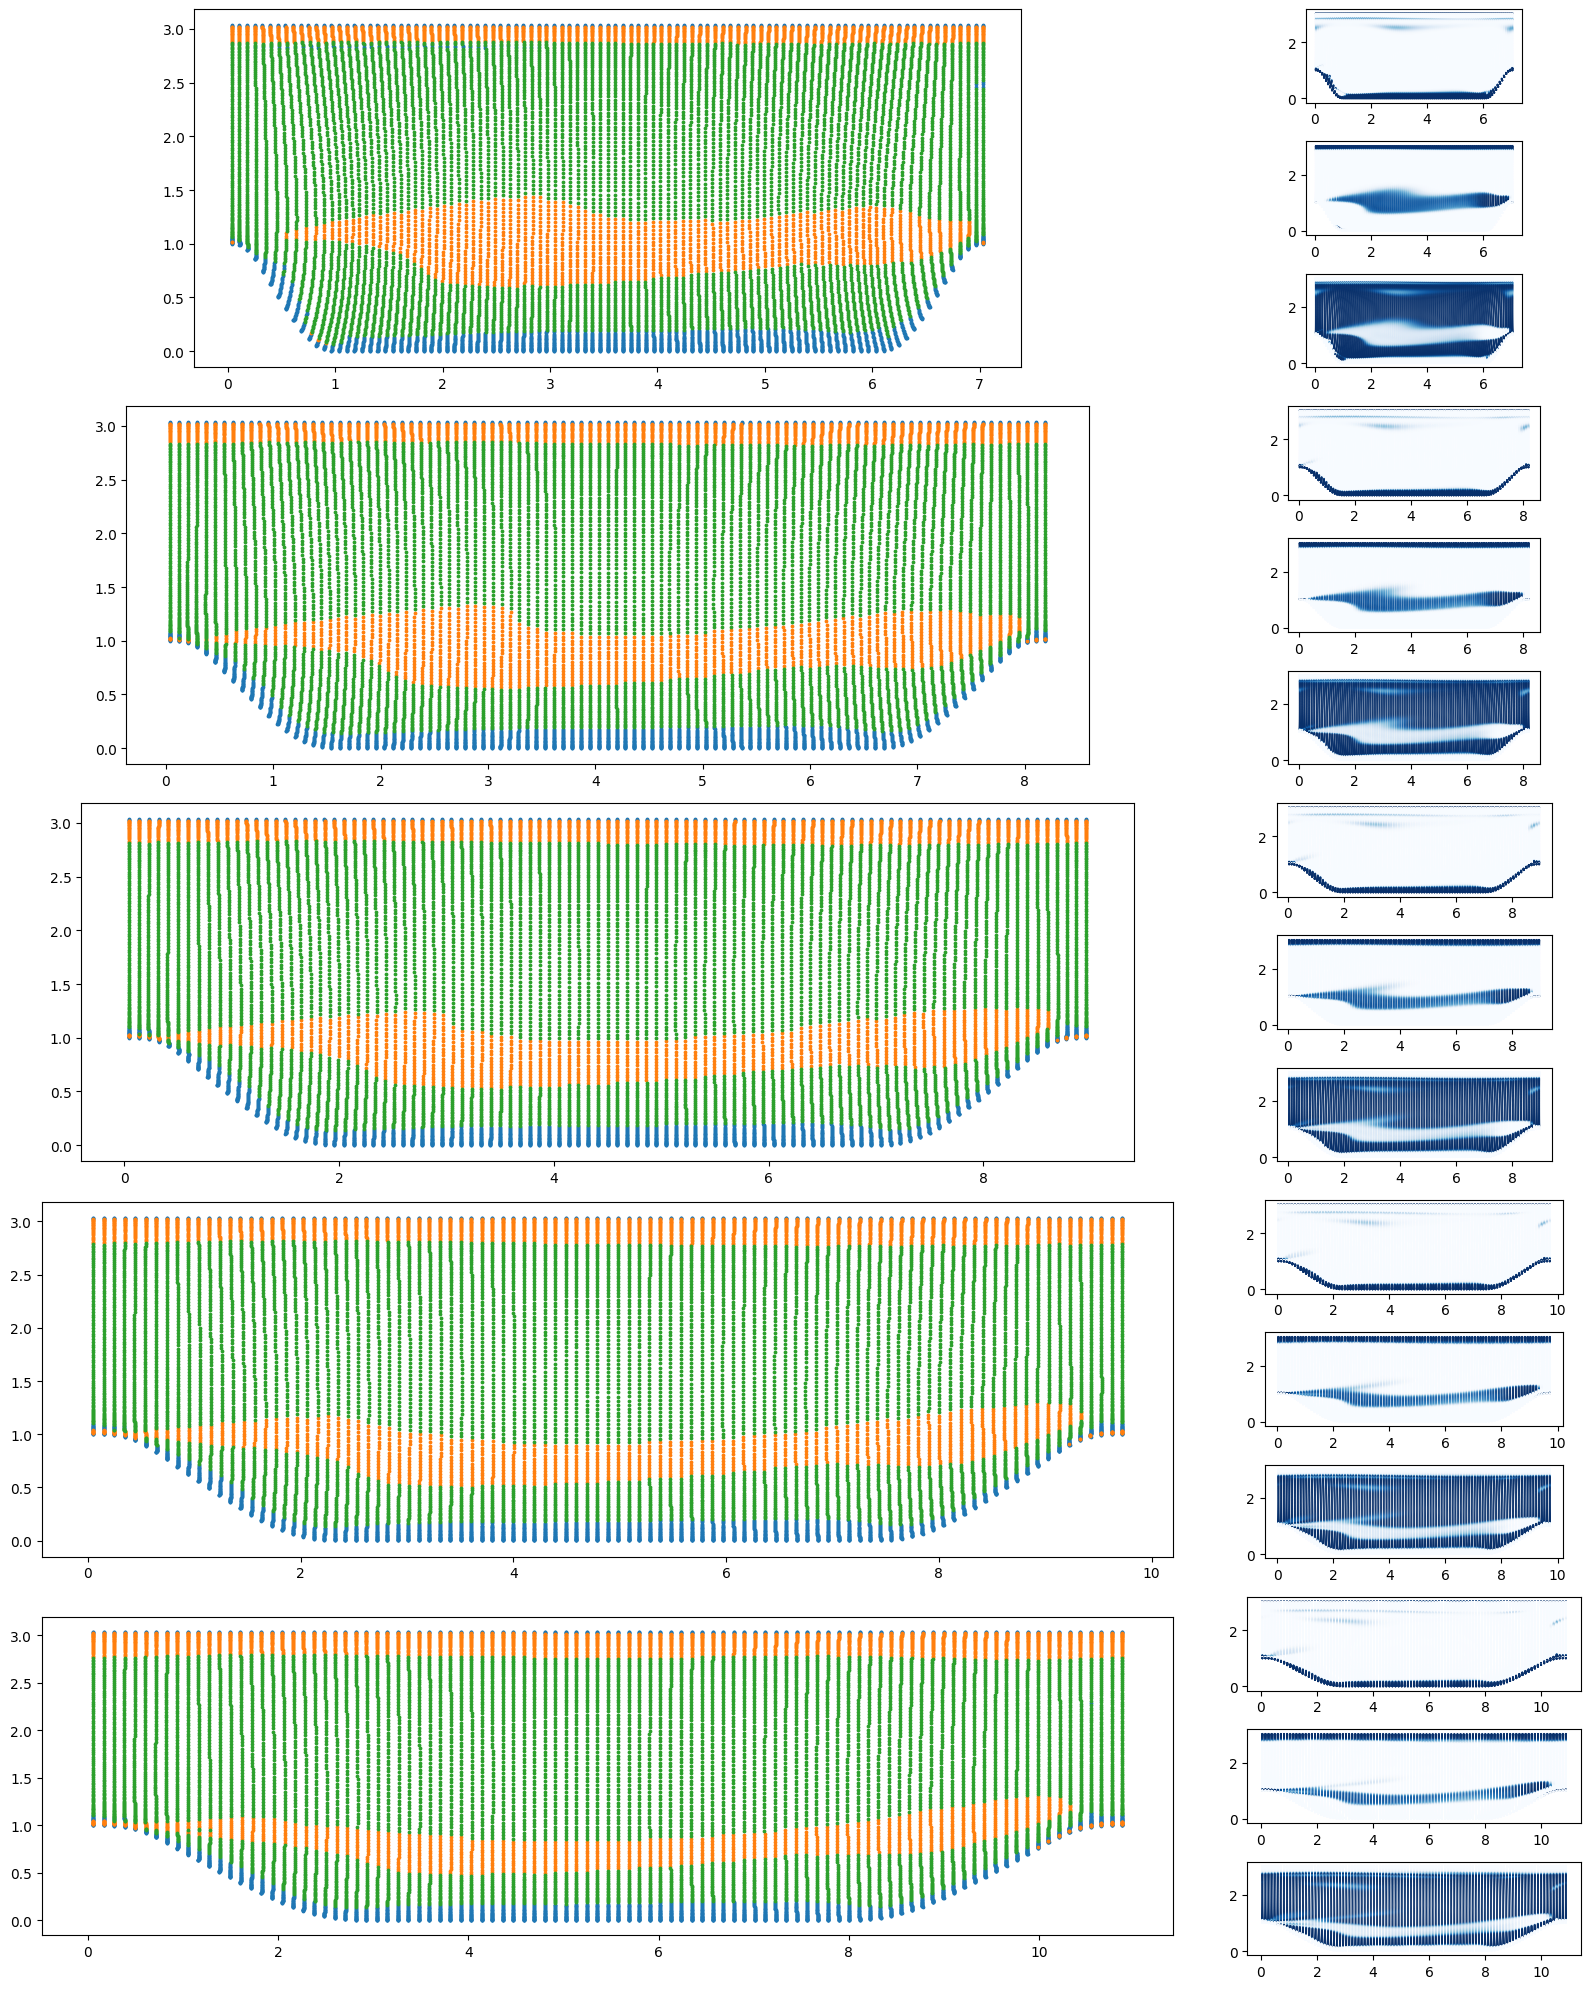

In [3]:
input_features = [
'komega_I1_1',
#komega_I2_1',
'komega_I1_3',
#'komega_I2_3',
'komega_I1_5',
#komega_I2_5',
#'komega_q5',
'komega_q6',
#'komega_q2',
#'komega_q9'
]
cases = ['case_0p5','case_0p8','case_1p0','case_1p5']
cases = ['case_1p0']
n_components = 3

X = df[df.Case.isin(cases)][input_features]
scaler_gmm = StandardScaler()
X = scaler_gmm.fit_transform(X)
#model = KMeans(n_clusters=4)
model_gmm = GaussianMixture(n_components=n_components, covariance_type='full',tol=1E-5,random_state=0)
model_gmm.fit(X)
print(f'Model iterations: {model_gmm.n_iter_}')
fig = plt.figure(layout="tight",figsize=(20,20))

gs = GridSpec(5*n_components, 2, figure=fig)

for i, case in enumerate(['case_0p5','case_0p8','case_1p0','case_1p2','case_1p5']):
    y = model_gmm.predict(scaler_gmm.transform(df[df.Case==case][input_features]))
    probab = model_gmm.predict_proba(scaler_gmm.transform(df[df.Case==case][input_features]))
    print(y)
    clusters = np.unique(y)
    print(clusters)
    Cx = df[df.Case == case]['komega_C_1']
    Cy = df[df.Case == case]['komega_C_2']
    ax_clusters = fig.add_subplot(gs[i*n_components:(i+1)*n_components,0])
    for cluster in clusters:    
        row_ix = np.where(y == cluster)
        ax_clusters.scatter(Cx.values[row_ix], Cy.values[row_ix],s=3.0)
        ax_clusters.set_aspect(1)
        ax_probab = fig.add_subplot(gs[(i*n_components+cluster),1])
        ax_probab.scatter(Cx.values, Cy.values,s=0.2, c=probab[:,cluster],cmap='Blues')
        ax_probab.set_aspect(1)
    # create scatter of these samples

y = model_gmm.predict(scaler_gmm.transform(df[input_features]))
print(np.unique(y, return_counts=True))


In [34]:
# GPU
df_full = pd.read_csv('/home/ryley/WDK/ML/dataset/komega_phll.csv')
df_full['Cluster'] = model_gmm.predict(scaler_gmm.transform(df_full[input_features]))
df_full['Proba_0'] = model_gmm.predict_proba(scaler_gmm.transform(df_full[input_features]))[:,0]
df_full['Proba_1'] = model_gmm.predict_proba(scaler_gmm.transform(df_full[input_features]))[:,1]
df_full['Proba_2'] = model_gmm.predict_proba(scaler_gmm.transform(df_full[input_features]))[:,2]

print(len(df_full))
val_case = 'case_1p2'
df_val_orig = df_full[df_full['Case'] == val_case].copy()
df_full = df_full[df_full['Case'] != val_case]
print(len(df_val_orig))
print(len(df_full))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
# NN hyperparameters

n_epochs = 20
labels = ['DNS_b_11']

class TurbDataset(Dataset):
    def __init__(self, df, input_features, labels):
        # convert into PyTorch tensors and remember them
        
        self.X = torch.from_numpy( df[input_features].values.astype(np.float32)).to(device)
        self.y = torch.from_numpy( df[labels].values.astype(np.float32)).to(device)

        del df
 
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

def preprocess_df(df):
    scaler = StandardScaler()
    df[input_features] = scaler.fit_transform(df[input_features])
    return df, scaler

def preprocess_df_val(df_valid,scaler):
    df_valid[input_features] = scaler.transform(df_valid[input_features])
    return df_valid


df0 = df_full[df_full['Cluster']==0]
df1 = df_full[df_full['Cluster']==1]
df2 = df_full[df_full['Cluster']==2]

for cluster_model, df in enumerate([df0, df1, df2]):
    print(f'Cluster model: {cluster_model}, training points: {len(df)}')
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    df, feature_scaler = preprocess_df(df)
    print(feature_scaler.mean_)
    df_val = preprocess_df_val(df_val_orig.copy(),feature_scaler)

    tDs = TurbDataset(df,input_features=input_features,labels=labels)
    loader = DataLoader(tDs, shuffle=True, batch_size=100)

    torch.cuda.synchronize()
    loss_values = []
    val_loss_values = []
    X_val = torch.from_numpy( df_val[input_features].values.astype(np.float32)).to(device)
    y_val = torch.from_numpy( df_val[labels].values.astype(np.float32)).to(device)

    for epoch in range(n_epochs):
        model.train()
        print(f'Epoch: {epoch}')
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            loss_values.append(loss_fn(model(torch.from_numpy( df[input_features].values.astype(np.float32)).to(device)),
                                       torch.from_numpy( df[labels].values.astype(np.float32)).to(device)).item())
            val_loss_values.append(loss_fn(model(X_val), y_val).item())
            
    sample = df.sample(n=15)
    sample['Predicted'] = model(torch.from_numpy(sample[input_features].values.astype(np.float32)).to(device)).cpu().detach().numpy()
    print(sample[labels + ['Predicted']])
    df_val_orig[f'Predictions_{cluster_model}'] = model(X_val).cpu().detach().numpy()


73755
14751
59004
Device: cuda:0
Cluster model: 0, training points: 11058
[ 0.00635658 -0.00559442 -0.10869197  3.69795791]
Epoch: 0
Epoch: 1


/tmp/ipykernel_34475/1905396461.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[input_features] = scaler.fit_transform(df[input_features])


Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
       DNS_b_11  Predicted
43252  0.017419   0.081288
110    0.391997   0.418365
27956  0.089756   0.098861
27461  0.073733   0.079897
12708  0.060831   0.071866
12113  0.055821   0.083556
43651 -0.009993   0.090732
42989  0.104640   0.067066
27838  0.046405   0.047104
14932  0.435112   0.428883
12043  0.060284   0.092193
41087 -0.099680   0.070261
13788  0.109700   0.112081
14438  0.137990   0.084144
73372 -0.020435   0.088872
Cluster model: 1, training points: 13934
[ 0.05260617 -0.04542924 -0.00590751  1.10257266]
Epoch: 0
Epoch: 1


/tmp/ipykernel_34475/1905396461.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[input_features] = scaler.fit_transform(df[input_features])


Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
       DNS_b_11  Predicted
60701  0.192357   0.206308
68866  0.116404   0.095953
915    0.364714   0.363183
1602   0.238611   0.235560
38028  0.103393   0.135495
38691  0.080904   0.146128
31281  0.189097   0.204189
38660  0.110979   0.116462
7283   0.163352   0.164628
67944  0.118966   0.118289
38248  0.133867   0.144598
23045  0.122643   0.123548
61321  0.212271   0.207170
16324  0.216809   0.227075
38374  0.123560   0.134922
Cluster model: 2, training points: 34012
[ 0.029495   -0.02447845 -0.07873379  0.36745458]
Epoch: 0


/tmp/ipykernel_34475/1905396461.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[input_features] = scaler.fit_transform(df[input_features])


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
       DNS_b_11  Predicted
33132  0.104100   0.115605
6040   0.163388   0.126357
67200  0.124735   0.129814
36080  0.176017   0.177143
70345  0.067945   0.067816
62234  0.111107   0.113520
39048  0.096453   0.098961
2228   0.163919   0.177440
35438  0.098629   0.083716
39652  0.077772   0.092593
6563   0.195855   0.185923
8601   0.139234   0.122579
7564   0.171132   0.176898
63033  0.077229   0.117362
7802   0.140997   0.143562


In [40]:
# GPU
df = pd.read_csv('/home/ryley/WDK/ML/dataset/komega_phll.csv')
print(len(df))
val_case = 'case_1p2'
df = df[df['Case'] != val_case]
print(len(df))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
# NN hyperparameters

n_epochs = 100
labels = ['DNS_b_11']

# Model creation
model = nn.Sequential(
    nn.Linear(4, 30),
    nn.ReLU(),
    #nn.Linear(50, 50),
    #nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
).to(device)

# Training parameters
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data hyperparameters


class TurbDataset(Dataset):
    def __init__(self, df, input_features, labels):
        # convert into PyTorch tensors and remember them
        
        self.X = torch.from_numpy( df[input_features].values.astype(np.float32)).to(device)
        self.y = torch.from_numpy( df[labels].values.astype(np.float32)).to(device)

        del df
 
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

def preprocess_df(df):
    scaler = StandardScaler()
    df[input_features] = scaler.fit_transform(df[input_features])
    return df, scaler

def preprocess_df_val(df_val,scaler):
    df_val[input_features] = scaler.transform(df_val[input_features])
    return df_val


df, feature_scaler = preprocess_df(df)
df_val = preprocess_df_val(df_val_orig.copy(),feature_scaler)
    
tDs = TurbDataset(df,input_features=input_features,labels=labels)
loader = DataLoader(tDs, shuffle=True, batch_size=100)

torch.cuda.synchronize()
loss_values = []
val_loss_values = []
X_val = torch.from_numpy( df_val[input_features].values.astype(np.float32)).to(device)
y_val = torch.from_numpy( df_val[labels].values.astype(np.float32)).to(device)

for epoch in range(n_epochs):
    model.train()
    print(f'Epoch: {epoch}')
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        loss_values.append(loss_fn(model(torch.from_numpy( df[input_features].values.astype(np.float32)).to(device)),
                                   torch.from_numpy( df[labels].values.astype(np.float32)).to(device)).item())
        val_loss_values.append(loss_fn(model(X_val), y_val).item())
    
df_val_orig[f'Predictions_fulldatasetmodel'] = model(X_val).cpu().detach().numpy()


73755
59004
Device: cuda:0
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epo

In [35]:
df_val_orig['Predictions_clusteredmodels'] = df_val_orig['Predictions_0']*df_val_orig['Proba_0'] + df_val_orig['Predictions_1']*df_val_orig['Proba_1'] + df_val_orig['Predictions_2']*df_val_orig['Proba_2']

In [47]:
def mse(y_true,y_pred):
    return np.sum((y_true-y_pred)**2)/len(y_true)
mse_clustered = mse(df_val_orig['Predictions_clusteredmodels'],df_val_orig['DNS_b_11'])
mse_full = mse(df_val_orig['Predictions_fulldatasetmodel'],df_val_orig['DNS_b_11'])

print(f'MSE clustered: {mse_clustered}')
print(f'MSE full: {mse_full}')

MSE clustered: 0.001362986332222653
MSE full: 0.0015918463882807726


Sample predictions:
       DNS_b_11  Predictions_fulldatasetmodel  Predictions_clusteredmodels
53904  0.096689                      0.099417                     0.093436
49713  0.127028                      0.131162                     0.125689
55329  0.037335                      0.012236                     0.036221
55674  0.079018                      0.084045                     0.078331
54208  0.094442                      0.090398                     0.100444
57777  0.093386                      0.097760                     0.082561
58865  0.120503                      0.185561                     0.072303
53997  0.092878                      0.103221                     0.101819
45828  0.233831                      0.256515                     0.253439
45579  0.309438                      0.311686                     0.288641
46766  0.194204                      0.181822                     0.181398
52420  0.152964                      0.168104                     0.169018
56550

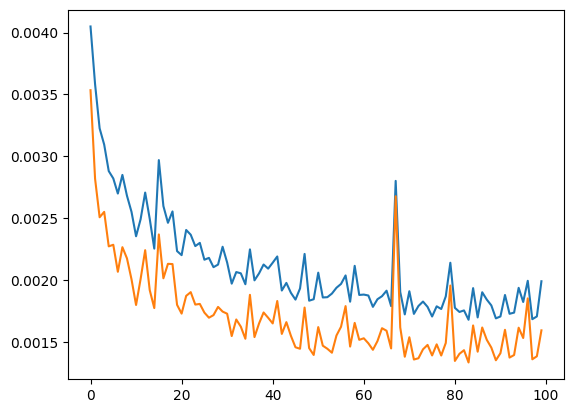

In [41]:
print(f'Sample predictions:')

sample = df_val_orig.sample(n=15)
print(sample[labels + ['Predictions_fulldatasetmodel','Predictions_clusteredmodels']])

plt.plot(loss_values)
plt.plot(val_loss_values)

Sample predictions:
       DNS_b_11  Predicted
67386  0.169944   0.156824
392    0.459060   0.494452
59765  0.489663   0.463791
36521  0.074864   0.133770
31537  0.210214   0.215484
24628  0.102101   0.112910
34573  0.171990   0.169377
11364  0.136718   0.147409
23758  0.015381   0.006664
59871  0.495538   0.453011
23570  0.069014   0.114117
1634   0.238967   0.211725
28578  0.085667   0.107714
64558  0.079038   0.091788
10386  0.020244   0.037079


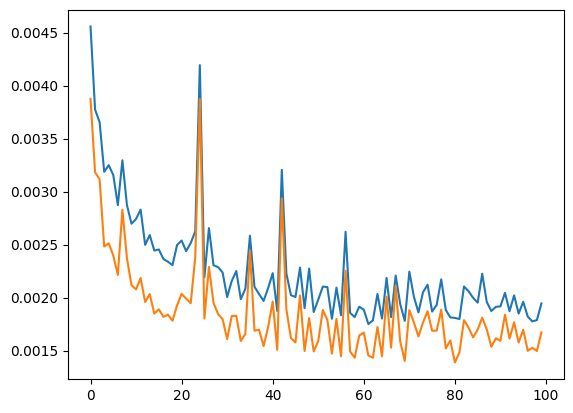

In [100]:
print(f'Sample predictions:')

sample = df.sample(n=15)
sample['Predicted'] = model(torch.from_numpy(sample[input_features].values.astype(np.float32)).to(device)).cpu().detach().numpy()
print(sample[labels + ['Predicted']])

plt.plot(loss_values)
plt.plot(val_loss_values)

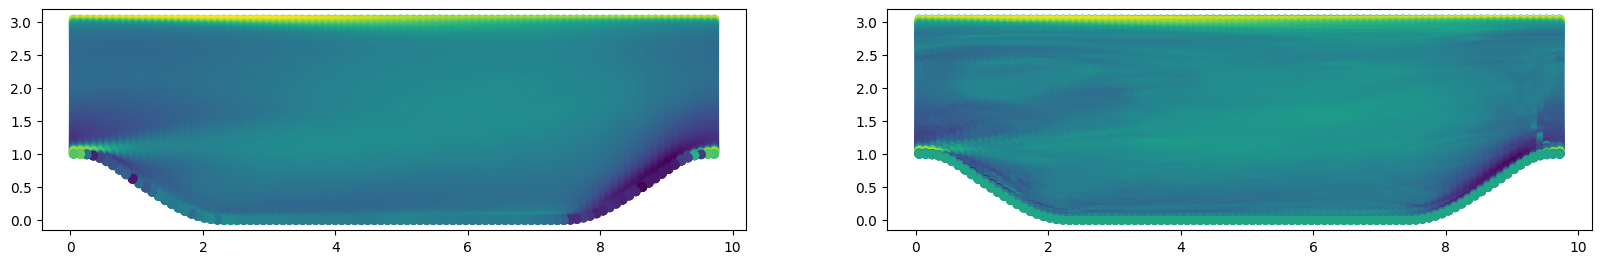

In [48]:
fig, ax = plt.subplots(1,2,figsize=(20,60))
predictions_val = model(X_val).cpu().detach().numpy()
ax[0].scatter(df_val_orig['komega_C_1'],df_val_orig['komega_C_2'],c=df_val_orig['DNS_b_11'])
ax[1].scatter(df_val_orig['komega_C_1'],df_val_orig['komega_C_2'],c = df_val_orig['Predictions_clusteredmodels'])

for axi in ax:
    axi.set_aspect(1)

Sample predictions:
       DNS_b_11  Predicted
39345  0.087674   0.095218
41342  0.054897   0.065219
10385  0.020267  -0.028462
66977  0.172051   0.131262
16625  0.173753   0.161957
10195  0.016374  -0.001720
38241  0.135421   0.125900
44304  0.361142   0.226073
65373  0.146514   0.186667
20940  0.162245   0.167898
38050  0.142933   0.127819
33336  0.096899   0.085205
24921  0.103085   0.097862
56204  0.074203   0.079873
54268  0.064967   0.051832


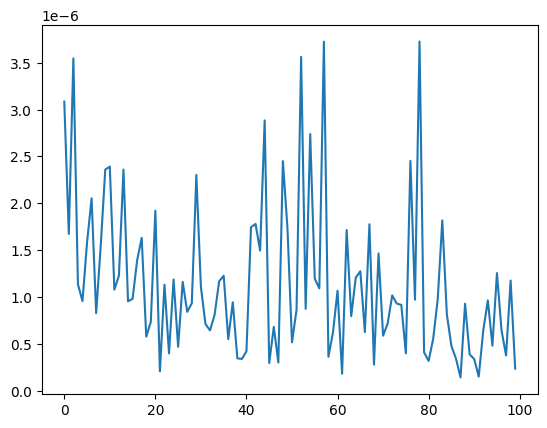

In [39]:
print(f'Sample predictions:')

sample = df.sample(n=15)
sample['Predicted'] = model(torch.from_numpy(sample[input_features].values.astype(np.float32)).to(device)).cpu().detach().numpy()
print(sample[labels + ['Predicted']])

plt.plot(loss_values)